### RESEARCH ON DATA FROM https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


## IMPORTED PACKAGES

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import ast
from itertools import chain
from wordcloud import WordCloud, STOPWORDS
import re

## UTIL FUNCTIONS

In [2]:
def print_df(df):
    with pd.option_context("display.max_columns", None):
        display(df.head(2))
        
def random_color():
    return "#" + "".join(random.choice("0123456789ABCDEF") for _ in range(6))

## DATA LOADING AND BASIC PREPROCESSING

- Load the dataset

In [30]:
# suppress warnings
meta_data_df = pd.read_csv("../data/movies_metadata.csv", low_memory=False)

- Basic information about the dataset

In [31]:
meta_data_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

- Drop meaningless columns

In [32]:
dropped_columns =  ["homepage", "imdb_id", "poster_path", "status", "tagline"]
meta_data_df = meta_data_df.drop(columns=dropped_columns)

- Population coercion

In [33]:
# convert the popularity to numeric values, NaN (missing values) if can't convert
meta_data_df["popularity"] = pd.to_numeric(meta_data_df["popularity"], errors="coerce")

- Adult: convert to true/false value and remove noise

In [34]:
meta_data_df["adult"].value_counts()

meta_data_df["adult"] = meta_data_df["adult"].astype(str).str.strip().str.lower()

meta_data_df["adult"] = meta_data_df["adult"].map({
    "true": True,
    "false": False
})

meta_data_df["adult"] = meta_data_df["adult"].fillna(True)

/tmp/ipykernel_9056/3446648582.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  meta_data_df["adult"] = meta_data_df["adult"].fillna(True)


- Production companies (each movie can have a list of production companies)

In [60]:
meta_data_df["production_companies"] = meta_data_df["production_companies"].fillna(value="[]")
meta_data_df['production_companies'] = meta_data_df['production_companies'].apply(ast.literal_eval)
meta_data_df['company_names'] = meta_data_df['production_companies'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Production countries, fill na with a simple empty list of countries

In [35]:
meta_data_df["production_countries"] = meta_data_df["production_countries"].fillna(value="[]")
# convert strings to python dict
meta_data_df['production_countries'] = meta_data_df['production_countries'].apply(ast.literal_eval)
# convert to a list of names of the countries
meta_data_df['country_names'] = meta_data_df['production_countries'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Genre generation

In [36]:
# convert str into python's dict
meta_data_df["genres"] = meta_data_df["genres"].apply(ast.literal_eval)
# convert to a list of genres
meta_data_df['genre_names'] = meta_data_df['genres'].apply(lambda x: [d['name'] for d in x] if isinstance(x, list) else [])

- Collection generation

In [41]:
def extract_collection(value):
    if pd.isna(value):
        return None
    try:
        data = ast.literal_eval(value)
        return data.get("name") if isinstance(data, dict) else None
    except (ValueError, SyntaxError):
        return None

# convert collection into python's dict
meta_data_df["collection_name"] = meta_data_df["belongs_to_collection"].apply(extract_collection)

- Spoken languages in the movie, a movie can have multiple spoken languages

In [70]:
def extract_languages(value):
    if pd.isna(value):
        return []
    
    try:
        data = ast.literal_eval(value)
        return [language["iso_639_1"] for language in data] if isinstance(data, list) else []
    except(ValueError, SyntaxError):
        return []

# convert to a list of spoken languages
meta_data_df["languages"] = meta_data_df["spoken_languages"].apply(extract_languages)

- Convert datetime into datetime type for manageble

In [42]:
# can convert -> Nan
meta_data_df['release_date'] = pd.to_datetime(meta_data_df['release_date'], errors='coerce')

- Final data frame

In [66]:
meta_data_df.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
id                           0
original_language           11
original_title               0
overview                   954
popularity                   6
production_companies         0
production_countries         0
release_date                90
revenue                      6
runtime                    263
spoken_languages             6
title                        6
video                        6
vote_average                 6
vote_count                   6
country_names                0
genre_names                  0
collection_name          40975
company_names                0
languages                    0
dtype: int64

In [72]:
print_df(meta_data_df)

,adult,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,video,vote_average,vote_count,country_names,genre_names,collection_name,company_names,languages
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Toy Story,False,7.7,5415.0,[United States of America],"[Animation, Comedy, Family]",Toy Story Collection,[Pixar Animation Studios],[en]
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Jumanji,False,6.9,2413.0,[United States of America],"[Adventure, Fantasy, Family]",None,"[TriStar Pictures, Teitler Film, Interscope Co...","[en, fr]"


## DATA VISUALIZATION

- Word cloud on titles

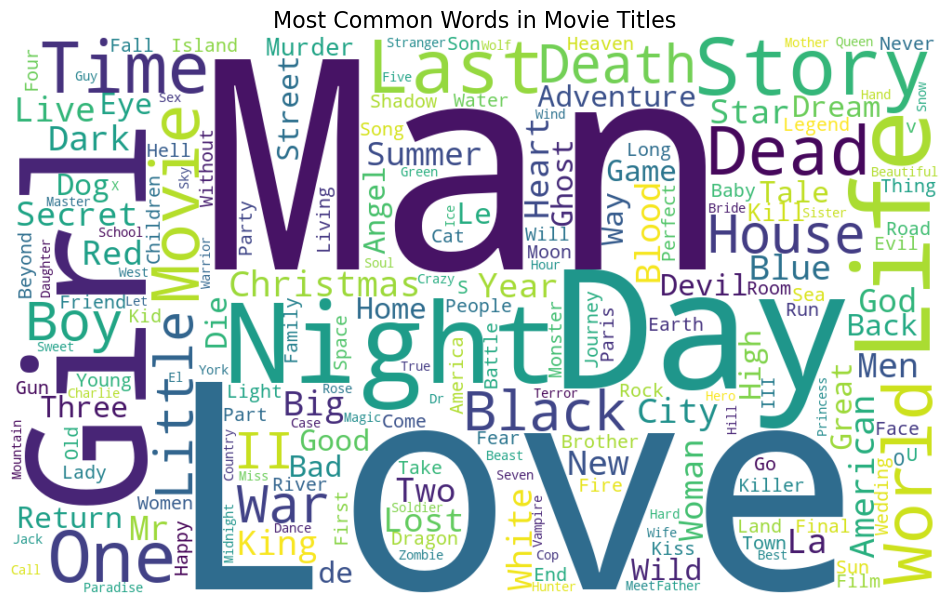

In [86]:
text = " ".join(meta_data_df["title"].dropna().astype(str))
text.lower()

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    stopwords=STOPWORDS,
    collocations=False
).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Movie Titles", fontsize=16)
plt.show()

- budget: Most of the values are 0

In [169]:
meta_data_df["budget"].value_counts()

budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
12200000        1
65700           1
64200           1
707503          1
8620000         1
Name: count, Length: 1226, dtype: int64

- revenue: Most of the revenue are 0

In [170]:
meta_data_df["revenue"].value_counts()

revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
100000.0          1
15073942.0        1
2807854.0         1
1942423.0         1
23833131.0        1
Name: count, Length: 6863, dtype: int64

- popularity values

In [172]:
meta_data_df["popularity"].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [48]:
(meta_data_df["popularity"] > 30).sum()

np.int64(111)

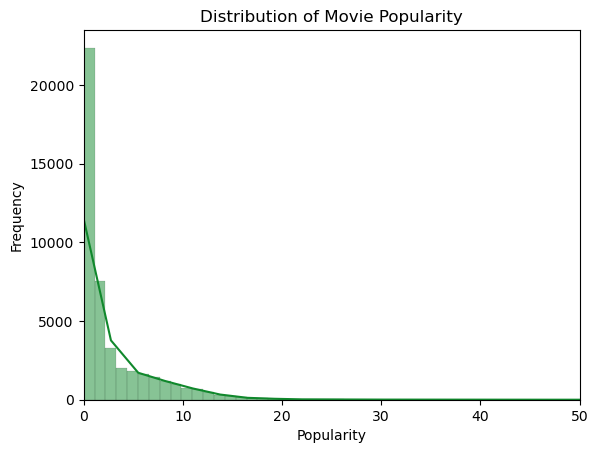

In [77]:
sns.histplot(meta_data_df["popularity"], bins=500, kde=True, color=random_color())

plt.xlim((0, 50))
plt.title("Distribution of Movie Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()


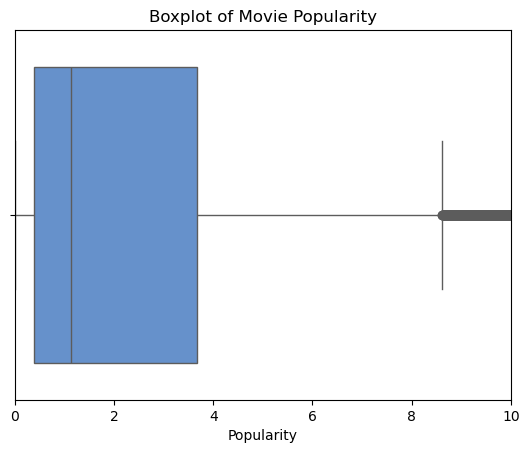

In [13]:
sns.boxplot(x=meta_data_df["popularity"], color=random_color())
plt.xlim((0, 10))
plt.title("Boxplot of Movie Popularity")
plt.xlabel("Popularity")
plt.show()


- runtime of the movies

In [14]:
meta_data_df["runtime"].describe()

count    45203.000000
mean        94.128199
std         38.407810
min          0.000000
25%         85.000000
50%         95.000000
75%        107.000000
max       1256.000000
Name: runtime, dtype: float64

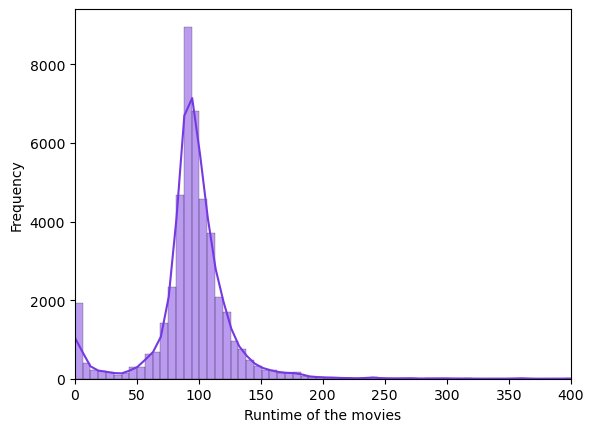

In [16]:
sns.histplot(data=meta_data_df, x="runtime", color=random_color(), bins=200, kde=True)

plt.xlim((0, 400))
plt.xlabel("Runtime of the movies")
plt.ylabel("Frequency")
plt.show()

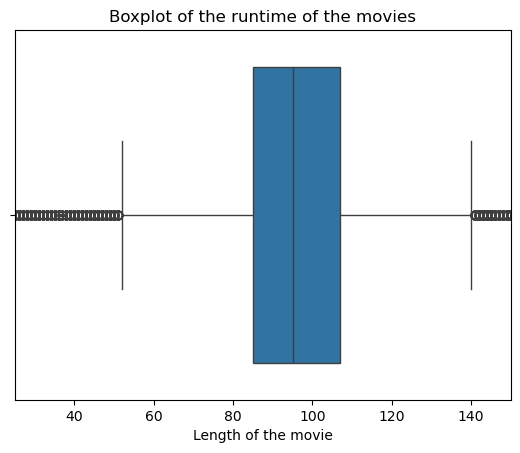

In [17]:
sns.boxplot(data=meta_data_df, x="runtime")

plt.xlim((25, 150))
plt.xlabel("Length of the movie")
plt.title("Boxplot of the runtime of the movies")
plt.show()

- Changes of runtime

In [18]:
# only used to view the change in runtime
meta_date = meta_data_df[meta_data_df["release_date"].notna()]

In [19]:
meta_date['year'] = meta_date['release_date'].dt.year
year_runtime = meta_date.groupby('year')['runtime'].mean().reset_index()

/tmp/ipykernel_9056/687814297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_date['year'] = meta_date['release_date'].dt.year


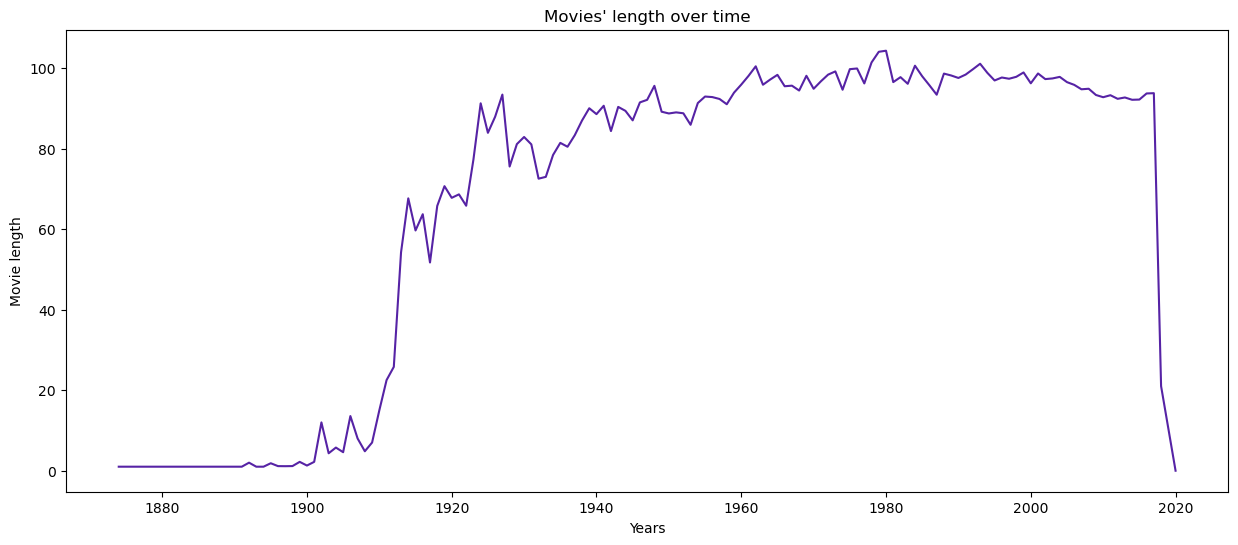

In [20]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=year_runtime, x="year", y="runtime", color=random_color())

plt.xlabel("Years")
plt.ylabel("Movie length")
plt.title("Movies' length over time")
plt.show()

- vote average: nearly normally distributed with mean 5.6?

In [80]:
meta_data_df["vote_average"].describe()

count    45460.000000
mean         5.618207
std          1.924216
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

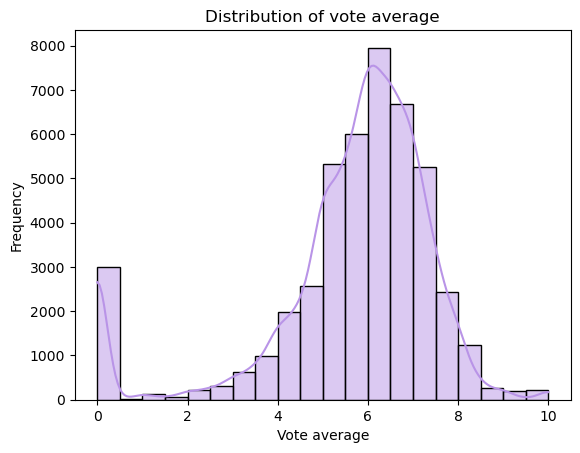

In [21]:
sns.histplot(meta_data_df["vote_average"], bins=20, kde=True, color=random_color())

plt.title("Distribution of vote average")
plt.xlabel("Vote average")
plt.ylabel("Frequency")
plt.show()

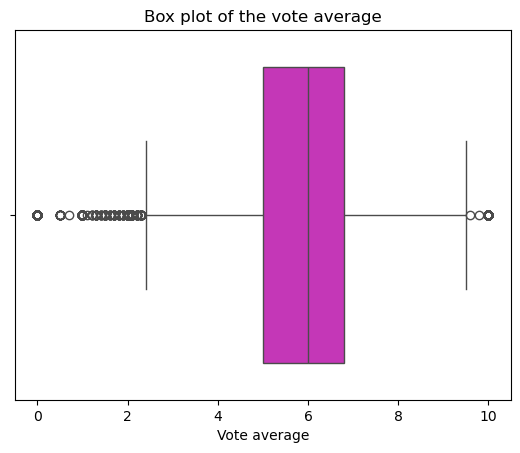

In [22]:
sns.boxplot(x=meta_data_df["vote_average"], color=random_color())

plt.xlabel("Vote average")
plt.title("Box plot of the vote average")
plt.show()

- vote_count, not so usefull as the number of vote is too small

In [23]:
meta_data_df["vote_count"].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [24]:
(meta_data_df["vote_count"] > 100).sum()

np.int64(6020)

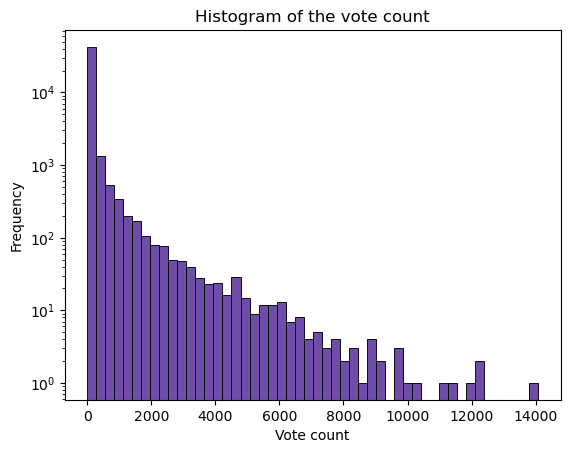

In [25]:
sns.histplot(data=meta_data_df, x="vote_count", bins=50, color=random_color())

plt.yscale("log")
plt.xlabel("Vote count")
plt.ylabel("Frequency")
plt.title("Histogram of the vote count")
plt.show()

- Most movies have very few votes, but some have high votes 10000

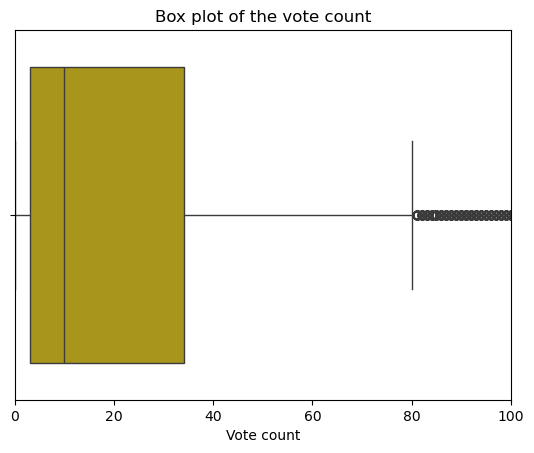

In [26]:
sns.boxplot(data=meta_data_df, x="vote_count", color=random_color())

plt.xlim((0, 100))
plt.xlabel("Vote count")
plt.title("Box plot of the vote count")
plt.show()

- Countries that produce the movies

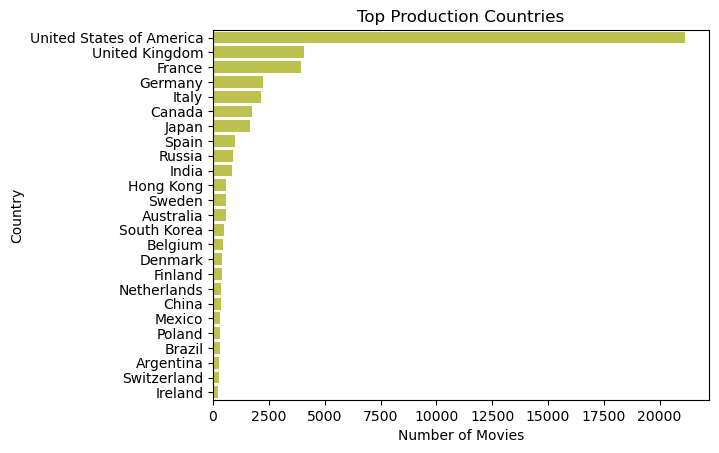

In [27]:
country_counts = pd.Series(list(chain.from_iterable(meta_data_df['country_names']))).value_counts()
top_countries = country_counts.head(25)

sns.barplot(x=top_countries.values, y=top_countries.index, color=random_color())  
plt.title("Top Production Countries")
plt.xlabel("Number of Movies")
plt.ylabel("Country")
plt.show()

- Genre calculation

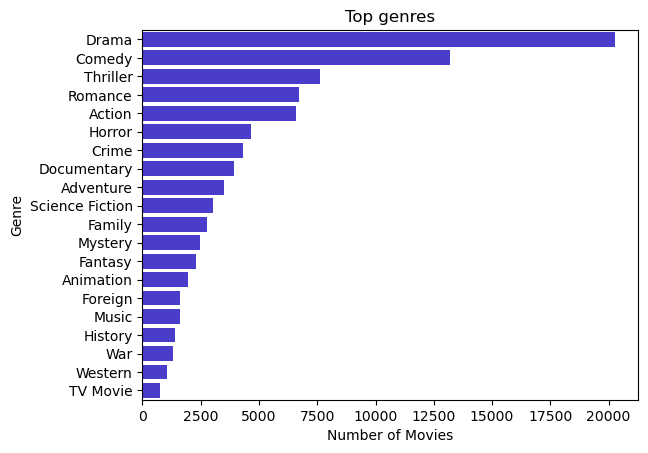

In [28]:
genre_counts = pd.Series(list(chain.from_iterable(meta_data_df['genre_names']))).value_counts()
top_genres = genre_counts.head(20)

sns.barplot(x=top_genres.values, y=top_genres.index, color=random_color())  
plt.title("Top genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()

- Movie collection

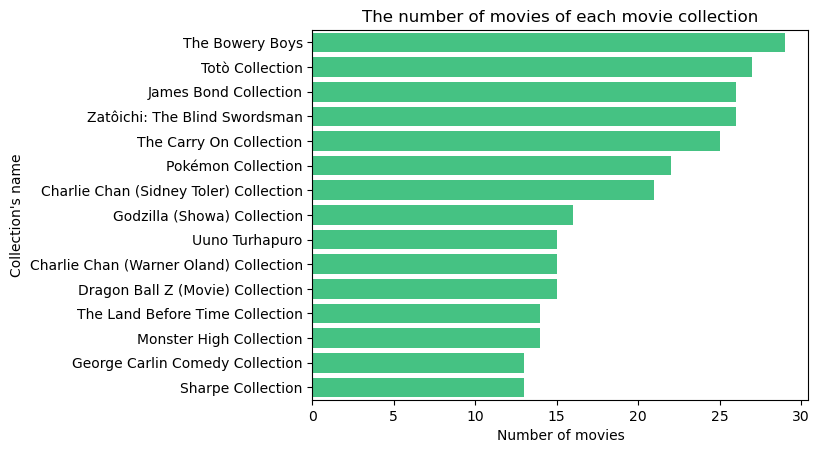

In [51]:
collection_counts = meta_data_df["collection_name"].value_counts().reset_index()
collection_counts.columns = ["collection_name", "movie_count"]
top_collection = collection_counts.head(15)

sns.barplot(data=top_collection, y="collection_name", x="movie_count", color=random_color())

plt.xlabel("Number of movies")
plt.ylabel("Collection's name")
plt.title("The number of movies of each movie collection")
plt.show()

In [52]:
collection_counts.describe()

,movie_count
count,1695.000000
mean,2.649558
std,2.280744
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,29.000000


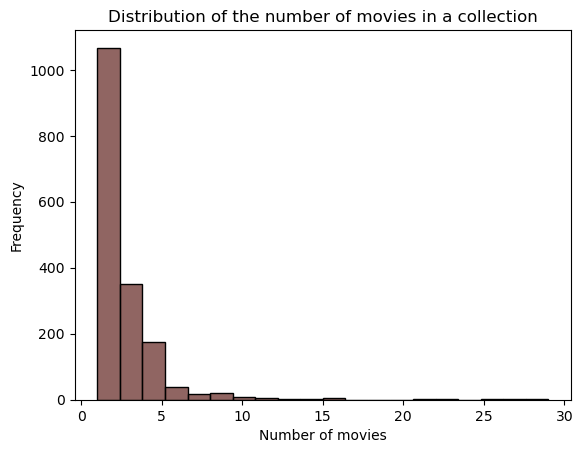

In [55]:
sns.histplot(data=collection_counts, x="movie_count", bins=20, color=random_color())

plt.xlabel("Number of movies")
plt.ylabel("Frequency")
plt.title("Distribution of the number of movies in a collection")
plt.show()

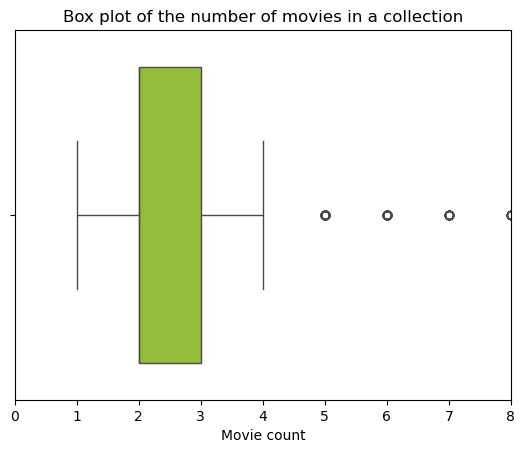

In [59]:
sns.boxplot(data=collection_counts, x="movie_count", color=random_color())

plt.xlim((0, 8))
plt.xlabel("Movie count")
plt.title("Box plot of the number of movies in a collection")
plt.show()

- Production companies

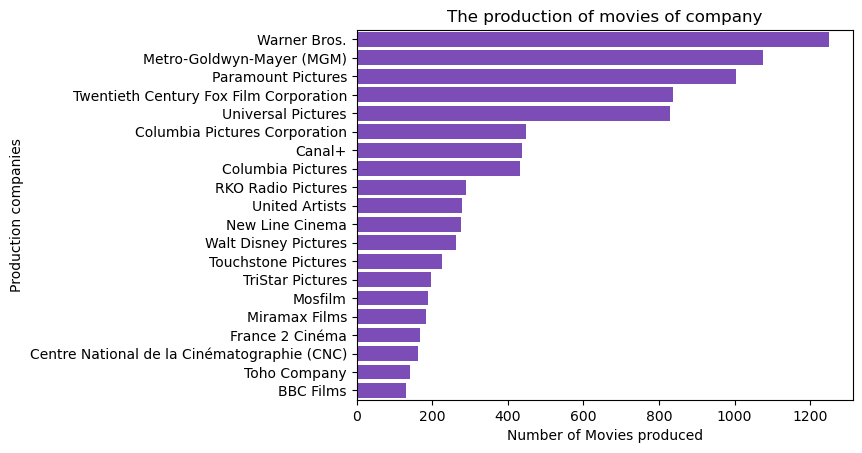

In [63]:
company_counts = pd.Series(list(chain.from_iterable(meta_data_df['company_names']))).value_counts()
top_companies = company_counts.head(20)

sns.barplot(x=top_companies.values, y=top_companies.index, color=random_color())  
plt.title("The production of movies of company")
plt.xlabel("Number of Movies produced")
plt.ylabel("Production companies")
plt.show()

- Spoken languages in movies

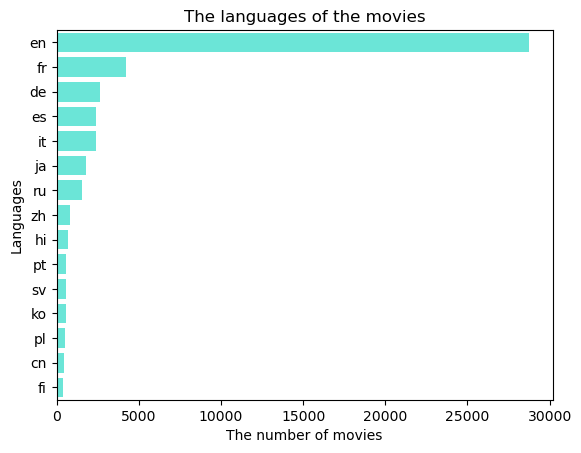

In [71]:
language_counts = pd.Series(list(chain.from_iterable(meta_data_df['languages']))).value_counts()
top_languages = language_counts.head(15)

sns.barplot(x=top_languages.values, y=top_languages.index, color=random_color())  
plt.title("The languages of the movies")
plt.xlabel("The number of movies")
plt.ylabel("Languages")
plt.show()